# Sidekick - Classification

#### Model
We then decide to try a simpler task. Instead of trying to predict a number of (future) points after some observations, we try now to classify whether a project $p$ will be successful ($c^{(p)} = 1$) or not ($c^{(p)} = 0$). Indeed, by separating the dataset in two classes (*successul* and *failed*), we notice that they have a very different profiles (look at the mean of both classes in [sidekick-classification]) and therefore should be easy to discriminate. To do so, we train one GP using the successful projects, one using the failed projects and try to determine whether a new, partially observed project will be successful or not. We learn $\theta_s$ the hyperparameters of a GP over $P_s$ *successful* projects only and $\theta_f$ the hyperparameters of a GP over the $P_f$ *failed* projects. That is, we maximize the log marginal likelihoods

$$\theta_s = \underset{\theta} {\arg\max} \sum_{p=1}^{P_s} \log p(\mathbf{y}_s^{(p)} \mid X, \theta)$$
$$\theta_f = \underset{\theta} {\arg\max} \sum_{p=1}^{P_f} \log p(\mathbf{y}_f^{(p)} \mid X, \theta),$$

where $\mathbf{y}_s$ and $\mathbf{y}_f$ denote the observations of the successful and failed projects respectively. We then determine the success state $c^{(p)}$ of a new project $p$ with partial observations $\mathbf{y}_{1:t}^{(p)}$ as

$$c^{(p)} = 
\begin{cases}
    1, & \text{ if } \log p(\mathbf{y}_{1:t}^{(p)} \mid X_{1:t}, \theta_s) > \log p(\mathbf{y}_{1:t}^{(p)} \mid X_{1:t}, \theta_f) \\
    0, & \text{ otherwise }
\end{cases}.$$

#### Results



In [2]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import pickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick

DATA_DIR = "../data/sidekick"

## Load data and separate successful from failed projects

In [3]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split()
successful = [project.money for project in projects_train if project.successful]
failed = [project.money for project in projects_train if not project.successful]

Loading data set...
Data loaded.


## Train GP-LIN on successful projects

In [4]:
X_train_s = np.ndarray(shape=(len(successful[0]), 1), buffer=np.arange(len(successful[0])), dtype=int) 
Y_train_s = np.array(successful).T
print(X_train_s.shape)
print(Y_train_s.shape)

kernel = GPy.kern.Linear(input_dim=1)
m_s = GPy.models.GPRegression(X_train_s, Y_train_s, kernel)
m_s.optimize()
display(m_s)

(1000, 1)
(1000, 6192)


GP_regression.,value,constraints,priors
linear.variances,0.000364552590415,+ve,
Gaussian_noise.variance,7.72270489278,+ve,


## Train GP-LIN on failed projects

In [7]:
X_train_f = np.ndarray(shape=(len(failed[0]), 1), buffer=np.arange(len(failed[0])), dtype=int) 
Y_train_f = np.array(failed).T
print(X_train_f.shape)
print(Y_train_f.shape)

kernel = GPy.kern.Linear(input_dim=1)
m_f = GPy.models.GPRegression(X_train_f, Y_train_f, kernel)
m_f.optimize()
display(m_f)

(1000, 1)
(1000, 6641)


GP_regression.,value,constraints,priors
linear.variances,0.570042059768,+ve,
Gaussian_noise.variance,1.30187634476e-09,+ve,


## Set up experiment

In [10]:
def classify_project(project, m_s, m_f, threshold=0.8):
    money = project.money[:int(np.floor(len(project.money)*threshold))]
    X_test = np.ndarray(shape=(len(money), 1), buffer=np.arange(len(money)), dtype=int) 
    Y_test = np.ndarray(shape=(len(money), 1), buffer=money, dtype=int)
    m_s_test.set_XY(X=X_test, Y=Y_test)
    m_f_test.set_XY(X=X_test, Y=Y_test)
    log_likelihood_successful = m_s_test.log_likelihood()
    log_likelihood_failed = m_f_test.log_likelihood()

    return int(log_likelihood_successful > log_likelihood_failed)

In [11]:
project_test = projects_test[0]
print(len(projects_test))
print(project_test)
m_s_test = m_s.copy()
m_f_test = m_f.copy()
state = classify_project(project_test, m_s_test, m_f_test)
print("Predicted %s" % "successful" if state else "failed")

print(m_s_test.log_likelihood())
print(m_f_test.log_likelihood())

3209
Project 1693026558 is failed
Predicted successful
-2.29147490209e+38
-1.62167816763e+47


## Run experiment

In [13]:
m_s_test = m_s.copy()
m_f_test = m_f.copy()
accuracy = []
predicted = []
actual = []
projects_test_small = projects_test[:100]
# np.random.shuffle(projects_test_small)
for project in projects_test_small:
    state = classify_project(project, m_s_test, m_f_test, threshold=1.0)
    predicted.append(state)
    actual.append(int(project.successful))
    accuracy.append(int(state == project.successful))
print("Accuracy %s" % np.mean(accuracy))
print(predicted)
print(actual)
print(accuracy)

Accuracy 0.52
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]


## Two different profiles

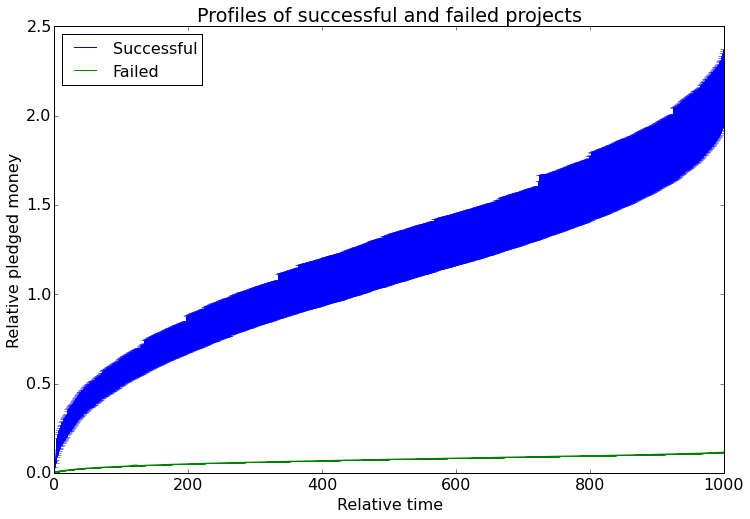

In [14]:
s = np.array(successful)
mean_s = np.mean(s, axis=0)
std_s = np.std(s, axis=0)
Ns = len(s)
f = np.array(failed)
mean_f = np.mean(f, axis=0)
std_f = np.std(f, axis=0)
Nf = len(f)
plt.errorbar(range(1000), mean_s, std_s / np.sqrt(Ns))
plt.errorbar(range(1000), mean_f, std_f / np.sqrt(Nf))
plt.xlabel('Relative time')
plt.ylabel('Relative pledged money')
plt.title('Profiles of successful and failed projects')
plt.legend(['Successful', 'Failed'], loc=2)
plt.savefig('two_profiles.pdf')
plt.show()